In [1]:
%reset -f

In [2]:
import redis
import json
from datetime import date
from datetime import timedelta

r = redis.Redis(host='localhost', port=6379, db=0)

dataCompany = json.loads(r.get('dataCompany')) 
cost_kWh_generation = float(dataCompany['priceSolarPanelGenerate'])

solarPanelGeneration = json.loads(r.get('solarPanelGeneration')) 
acum_kWh_generation = float(solarPanelGeneration['kWh_acumGeneration'])

prevDay = (date.today() - timedelta(days = 1)).strftime('%d/%m/%y')

#Generation history
data_setGenerationHistory = {"date":prevDay,"kWh":round(acum_kWh_generation,6),"benefit":round((acum_kWh_generation*cost_kWh_generation),3)}

json_dumpGenerationHistory = json.dumps(data_setGenerationHistory)
r.lpush('generationHistoryList',json_dumpGenerationHistory) 


52

In [3]:
import redis
import json
from datetime import date
from datetime import timedelta

r = redis.Redis(host='localhost', port=6379, db=0)

dataCompany = json.loads(r.get('dataCompany')) 
cost_kWh_consumption = float(dataCompany['pricekWh'])

energyConsumption = json.loads(r.get('energyConsumption')) 
acum_kWh_consumption = float(energyConsumption['kWh_acum'])

given_date = (date.today() - timedelta(days = 1))
#given_date = date(2019, 6, 23)
first_day_of_month = given_date.replace(day=1).strftime('%d/%m/%y')
 
#print("\nFirst day of month: ", first_day_of_month, "\n")

#Consumption history

#Buscamos si en la tabla hash esta la key del primer dia este mes.

returnRedis = r.hget('consumptionHistoryHashList', first_day_of_month)
#print(returnRedis)

if returnRedis!=None:
    #Se ha encontrado la key, por lo tanto actualizamos los kWh acum del mes.
    tempJson = json.loads(returnRedis)
    tempJson['kWh']+=round(acum_kWh_consumption,6)
    tempJson['cost']=round((tempJson['kWh']*cost_kWh_consumption),3)
    
    json_dumpConsumptionHistoryUPD = json.dumps(tempJson)
    r.hset('consumptionHistoryHashList',first_day_of_month,json_dumpConsumptionHistoryUPD)
    
else:
    #No se ha encontrado la key, por lo tanto creamos una nueva.
    print("No hay nada!")
    
    # Guaranteed to get the next month. Force any_date to 28th and then add 4 days.
    next_month = (date.today() - timedelta(days = 1)).replace(day=28) + timedelta(days=4)
    #next_month = date(2019, 6, 23).replace(day=28) + timedelta(days=4)
    # Subtract all days that are over since the start of the month.
    last_day_of_month = (next_month - timedelta(days=next_month.day)).strftime('%d/%m/%y')
    
    data_setConsumptionHistory = {"endPeriod":last_day_of_month,"kWh":round(acum_kWh_consumption,6),"cost":round((acum_kWh_consumption*cost_kWh_consumption),3)}
    json_dumpConsumptionHistory = json.dumps(data_setConsumptionHistory)
    r.hset('consumptionHistoryHashList',first_day_of_month,json_dumpConsumptionHistory)


In [4]:
pathDataCSV = 'data/REDD/low_freq2'
pathDataH5 = 'data/data.h5'

In [5]:
import redis
import json
r = redis.Redis(host='localhost', port=6379, db=0)

appliances = json.loads(r.get('dataAppliances')) 

selectedAppliances = []

if appliances['Refrigerator']==True:
    selectedAppliances.append('fridge')
if appliances['Dryer']==True:
    selectedAppliances.append('washer dryer')
if appliances['Microwave']==True:
    selectedAppliances.append('microwave')
if appliances['Dishwasher']==True:
    selectedAppliances.append('dish washer')
if appliances['Oven']==True:
    selectedAppliances.append('electric oven')
if appliances['Electric Hob']==True:
    selectedAppliances.append('electric stove')
if appliances['Electric heater']==True:
    selectedAppliances.append('electric space heater')
    
print(selectedAppliances)

['fridge', 'microwave', 'electric oven']


In [6]:
import csv
rtList = r.lrange("rtList2", 0, 86400);

rtList.reverse()


with open(pathDataCSV+'/house_1/Generadochannel_1Mal.dat', 'w', newline='') as file:
    writer = csv.writer(file, delimiter=' ')
    for i in rtList:
        data = json.loads(i)
        writer.writerow([data['epochTime'], round(data['kW']*1000,2)])

In [7]:
#from nilmtk.dataset_converters import convert_redd
from nilmtk.dataset_converters import convert_reddAlex
convert_reddAlex(pathDataCSV, pathDataH5)
#convert_redd('data/REDD/dades', 'data/dades.h5')

Loading house 1... 1 3 4 5 6 7 8 9 
Loaded metadata
Done converting YAML metadata to HDF5!
Done converting REDD to HDF5!


In [8]:
from __future__ import print_function, division
import time

from matplotlib import rcParams
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from six import iteritems

from nilmtk import DataSet, TimeFrame, MeterGroup, HDFDataStore
from nilmtk.legacy.disaggregate import CombinatorialOptimisation, FHMM
import nilmtk.utils

%matplotlib inline

In [9]:
rcParams['figure.figsize'] = (13, 6)

In [10]:
train = DataSet(pathDataH5)
test = DataSet(pathDataH5)

#print(test.buildings[1].elec.mains().load(physical_quantity = 'power', ac_type = 'apparent', sample_period=1))

In [11]:
building = 1

In [12]:
from datetime import date
from datetime import timedelta

day = (date.today() - timedelta(days = 1)).strftime('%Y-%m-%d')

print("Date to predict appliances consuption"+day)

#train => Model
#test => Data meter

#train.set_window(end=day)
#test.set_window(start=day)

#train.set_window(end="2021-10-20")
#test.set_window(start="2021-10-20")

train.set_window(end="2011-05-01")
test.set_window(start="2011-05-01")

train_elec = train.buildings[1].elec
test_elec = test.buildings[1].elec

Date to predict appliances consuption2021-10-29


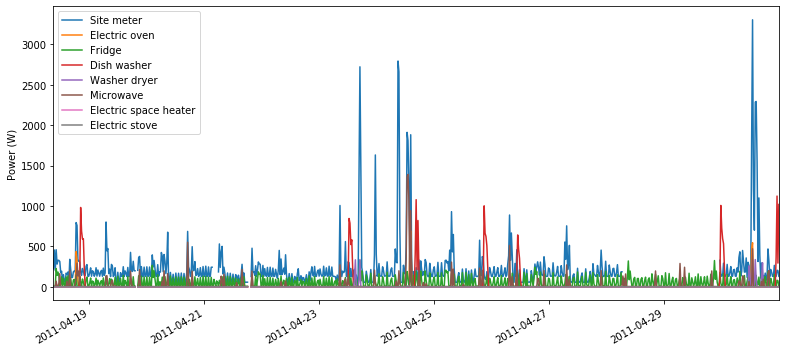

In [13]:
train_elec.plot()

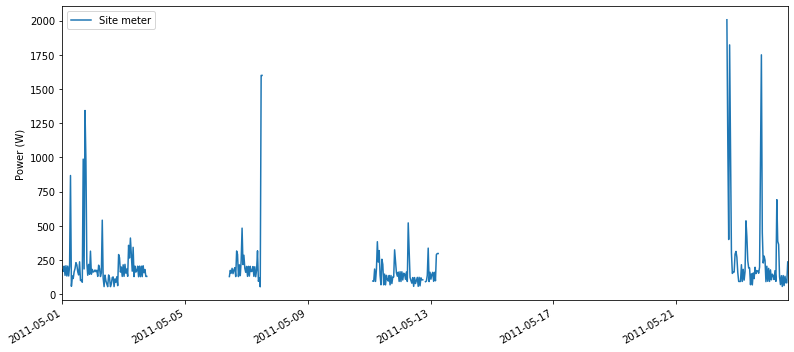

In [14]:
test_elec.mains().plot()

In [15]:
def predict(clf, test_elec, sample_period, timezone):
    pred = {}
    gt= {}

    # "ac_type" varies according to the dataset used. 
    # Make sure to use the correct ac_type before using the default parameters in this code.    
    for i, chunk in enumerate(test_elec.mains().load(physical_quantity = 'power', ac_type = 'apparent', sample_period=sample_period)):
        chunk_drop_na = chunk.dropna()
        pred[i] = clf.disaggregate_chunk(chunk_drop_na)
        gt[i]={}

        for meter in test_elec.submeters().meters:
            # Only use the meters that we trained on (this saves time!)    
            gt[i][meter] = next(meter.load(physical_quantity = 'power', ac_type = 'active', sample_period=sample_period))
        gt[i] = pd.DataFrame({k:v.squeeze() for k,v in iteritems(gt[i]) if len(v)}, index=next(iter(gt[i].values())).index).dropna()
        
    # If everything can fit in memory
    gt_overall = pd.concat(gt)
    gt_overall.index = gt_overall.index.droplevel()
    pred_overall = pd.concat(pred)
    pred_overall.index = pred_overall.index.droplevel()

    # Having the same order of columns
    gt_overall = gt_overall[pred_overall.columns]
    
    #Intersection of index
    gt_index_utc = gt_overall.index.tz_convert("UTC")
    pred_index_utc = pred_overall.index.tz_convert("UTC")
    common_index_utc = gt_index_utc.intersection(pred_index_utc)
    
    common_index_local = common_index_utc.tz_convert(timezone)
    gt_overall = gt_overall.loc[common_index_local]
    pred_overall = pred_overall.loc[common_index_local]
    appliance_labels = [m for m in gt_overall.columns.values]
    gt_overall.columns = appliance_labels
    pred_overall.columns = appliance_labels
    return gt_overall, pred_overall

In [16]:
#top_5_train_elec = train_elec.submeters().select_top_k(k=2)
top_5_train_elec = train_elec.submeters().select_using_appliances(type=selectedAppliances)

classifiers = {'CO':CombinatorialOptimisation(), 'FHMM':FHMM()}
predictions = {}
sample_period = 120 #Cambiar el sample_period a 1, cuando este en produccion
for clf_name, clf in classifiers.items():
    print("*"*20)
    print(clf_name)
    print("*" *20)
    start = time.time()
    # Note that we have given the sample period to downsample the data to 1 minute. 
    # If instead of top_5 we wanted to train on all appliance, we would write 
    # fhmm.train(train_elec, sample_period=60)
    clf.train(top_5_train_elec, sample_period=sample_period)
    end = time.time()
    print("Runtime =", end-start, "seconds.")
    gt, predictions[clf_name] = predict(clf, test_elec, sample_period, train.metadata['timezone'])

********************
CO
********************
Training model for submeter 'ElecMeter(instance=4, building=1, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])'
Training model for submeter 'ElecMeter(instance=7, building=1, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])'
Training model for submeter 'ElecMeter(instance=3, building=1, dataset='REDD', appliances=[Appliance(type='electric oven', instance=1)])'
Done training!
Runtime = 1.7284467220306396 seconds.
Estimating power demand for 'ElecMeter(instance=4, building=1, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])'
Estimating power demand for 'ElecMeter(instance=7, building=1, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])'
Estimating power demand for 'ElecMeter(instance=3, building=1, dataset='REDD', appliances=[Appliance(type='electric oven', instance=1)])'
********************
FHMM
********************
Training model for submeter 'ElecMeter(instance=4

In [17]:
appliance_labels = [m.label() for m in gt.columns.values]

In [18]:
gt.columns = appliance_labels
predictions['CO'].columns = appliance_labels
predictions['FHMM'].columns = appliance_labels
#Create DataFrame
df = pd.DataFrame({predictions['CO'].head(25).to_string()})

#Convert the Columns to string
df[df.columns]=df[df.columns].astype(str)

#Create the list of column separator width 
SepWidth = [5,6,3,8]

#Temp dict
tempdf = {}
#Convert all the column to series
for i, eCol in enumerate(df):
    tempdf[i] = pd.Series(df[eCol]).str.pad(width=SepWidth[i])

#Final DataFrame
Fdf = pd.concat(tempdf, axis=1)
#print Fdf
#Export to csv
Fdf.to_csv("./testCO.txt", sep='\t', index=False, header=False, encoding='utf-8')




In [19]:
predictions['CO'].head(25)

,Fridge,Microwave,Electric oven
2011-05-01 00:00:00-04:00,198.0,0.0,0.0
2011-05-01 00:02:00-04:00,198.0,0.0,0.0
2011-05-01 00:04:00-04:00,198.0,0.0,0.0
2011-05-01 00:06:00-04:00,198.0,0.0,0.0
2011-05-01 00:08:00-04:00,198.0,0.0,0.0
2011-05-01 00:10:00-04:00,198.0,0.0,0.0
2011-05-01 00:12:00-04:00,198.0,0.0,0.0
2011-05-01 00:14:00-04:00,198.0,0.0,0.0
2011-05-01 00:16:00-04:00,198.0,0.0,0.0
2011-05-01 00:18:00-04:00,198.0,0.0,0.0


In [20]:
predictions['FHMM'].head(25)

,Fridge,Microwave,Electric oven
2011-05-01 00:00:00-04:00,6.0,105.0,0.0
2011-05-01 00:02:00-04:00,6.0,105.0,3.0
2011-05-01 00:04:00-04:00,6.0,105.0,3.0
2011-05-01 00:06:00-04:00,6.0,105.0,3.0
2011-05-01 00:08:00-04:00,6.0,105.0,3.0
2011-05-01 00:10:00-04:00,6.0,105.0,3.0
2011-05-01 00:12:00-04:00,6.0,105.0,3.0
2011-05-01 00:14:00-04:00,6.0,105.0,3.0
2011-05-01 00:16:00-04:00,6.0,105.0,3.0
2011-05-01 00:18:00-04:00,6.0,105.0,3.0


In [21]:
gt.head(25)

,Fridge,Microwave,Electric oven
2011-05-01 00:00:00-04:00,6.000000,4.0,2.500000
2011-05-01 00:02:00-04:00,6.000000,4.0,2.500000
2011-05-01 00:04:00-04:00,6.166667,4.0,1.833333
2011-05-01 00:06:00-04:00,6.750000,4.0,0.000000
2011-05-01 00:08:00-04:00,6.580645,4.0,0.000000
2011-05-01 00:10:00-04:00,6.718750,4.0,0.000000
2011-05-01 00:12:00-04:00,6.612903,4.0,0.000000
2011-05-01 00:14:00-04:00,6.718750,4.0,0.000000
2011-05-01 00:16:00-04:00,6.781250,4.0,0.000000
2011-05-01 00:18:00-04:00,6.870968,4.0,0.000000


In [22]:
print(predictions['FHMM'])

                           Fridge  Microwave  Electric oven
2011-05-01 00:00:00-04:00     6.0      105.0            0.0
2011-05-01 00:02:00-04:00     6.0      105.0            3.0
2011-05-01 00:04:00-04:00     6.0      105.0            3.0
2011-05-01 00:06:00-04:00     6.0      105.0            3.0
2011-05-01 00:08:00-04:00     6.0      105.0            3.0
...                           ...        ...            ...
2011-05-24 14:30:00-04:00   167.0      105.0            0.0
2011-05-24 14:32:00-04:00   167.0      105.0            0.0
2011-05-24 14:34:00-04:00   167.0      105.0            0.0
2011-05-24 15:54:00-04:00   167.0      105.0            0.0
2011-05-24 15:56:00-04:00   167.0      105.0            0.0

[5520 rows x 3 columns]


In [135]:
import redis
import json
from datetime import date
from datetime import timedelta
from datetime import time

r = redis.Redis(host='localhost', port=6379, db=0)

def is_weekend(d):
    return d.weekday() > 4

def is_between(timeD, startT, endT):
    if endT == time(0,0):
        return startT <= timeD.time() <= time(23,59)
    else:
        return startT <= timeD.time() < endT
    

dataCompany2 = json.loads(r.get('dataCompany')) 
rateType = dataCompany2['rateType']
hourlyDiscrimination = dataCompany2['hourlyDiscrimination']

def getCostkWh(timestampDateRecv):
    if rateType=="regulated":
        print("dentro discriminacion horaria regulated")
        #aqui habria que conectarse con alguna api que nos diera el precio en especifico para tal hora.
    elif rateType=="fixed":
        if hourlyDiscrimination=="true":
            if is_weekend(timestampDateRecv):
                print("dentro discriminacion horaria fixed weekend")
                return float(dataCompany2['pricekWhValle'])
            else:
                if (is_between(timestampDateRecv, time(10,0), time(14,0)) or is_between(timestampDateRecv, time(18,0), time(22,0))):
                    print("dentro discriminacion horaria fixed lab 10-14 18-22")
                    return float(dataCompany2['pricekWhPunta'])
                elif (is_between(timestampDateRecv, time(8,0), time(10,0)) or is_between(timestampDateRecv, time(14,0), time(18,0)) or is_between(timestampDateRecv, time(22,0), time(0,0)) ):
                    print("dentro discriminacion horaria fixed lab 8-10 14-18 22-24")
                    return float(dataCompany2['pricekWhLlano'])
                elif is_between(timestampDateRecv, time(0,0), time(8,0)):
                    print("dentro discriminacion horaria fixed lab 0-8")
                    return float(dataCompany2['pricekWhValle'])
        elif hourlyDiscrimination=="false":
            print("NO discriminacion horaria fixed")
            return float(dataCompany2['pricekWh'])

In [143]:
import math

#day = (date.today() - timedelta(days = 1)).strftime('%Y-%m-%d')
day = '2011-05-01'

dataCompany = json.loads(r.get('dataCompany')) 

tempkWhFridge=0
tempkWhDryer=0
tempkWhMicrowave=0
tempkWhDishwasher=0
tempkWhElectricoven=0
tempkWhHob=0
tempkWhHeater=0

tempCostFridge=0
tempCostDryer=0
tempCostMicrowave=0
tempCostDishwasher=0
tempCostElectricoven=0
tempCostHob=0
tempCostHeater=0

typePrediction='FHMM'


if predictions[typePrediction].loc[day+' 00:00:00':day+' 23:59:00'].index.size > 0:
    if appliances['Refrigerator']==True:
        indexI=0
        for predictionTempFridge in predictions[typePrediction].loc[day+' 00:00:00':day+' 23:59:00'].Fridge:
            print(predictions[typePrediction].loc[day+' 00:00:00':day+' 23:59:00'].index[indexI])
            print(getCostkWh(predictions[typePrediction].loc[day+' 00:00:00':day+' 23:59:00'].index[indexI]))
            tempkWhFridge += ((predictionTempFridge/1000)*0.01666666667)
            tempCostFridge += (((predictionTempFridge/1000)*0.01666666667)*getCostkWh(predictions[typePrediction].loc[day+' 00:00:00':day+' 23:59:00'].index[indexI]))
            indexI=indexI+1
    if appliances['Dryer']==True:
        indexI=0
        for predictionTempDryer in predictions[typePrediction].loc[day+' 00:00:00':day+' 23:59:00']["Washer dryer"]:
            tempkWhDryer += ((predictionTempDryer/1000)*0.01666666667)
            tempCostDryer += (((predictionTempDryer/1000)*0.01666666667)*getCostkWh(predictions[typePrediction].loc[day+' 00:00:00':day+' 23:59:00'].index[indexI]))
            indexI=indexI+1
    if appliances['Microwave']==True:
        indexI=0
        for predictionTempMicrowave in predictions[typePrediction].loc[day+' 00:00:00':day+' 23:59:00'].Microwave:
            tempkWhMicrowave += ((predictionTempMicrowave/1000)*0.01666666667)
            tempCostMicrowave += (((predictionTempMicrowave/1000)*0.01666666667)*getCostkWh(predictions[typePrediction].loc[day+' 00:00:00':day+' 23:59:00'].index[indexI]))
            indexI=indexI+1
    if appliances['Dishwasher']==True:
        indexI=0
        for predictionTempDishwasher in predictions[typePrediction].loc[day+' 00:00:00':day+' 23:59:00']["Dish washer"]:
            tempkWhDishwasher += ((predictionTempDishwasher/1000)*0.01666666667)
            tempCostDishwasher += (((predictionTempDishwasher/1000)*0.01666666667)*getCostkWh(predictions[typePrediction].loc[day+' 00:00:00':day+' 23:59:00'].index[indexI]))
            indexI=indexI+1
    if appliances['Oven']==True:
        indexI=0
        for predictionTempElectricoven in predictions[typePrediction].loc[day+' 00:00:00':day+' 23:59:00']["Electric oven"]:
            tempkWhElectricoven += ((predictionTempElectricoven/1000)*0.01666666667)
            tempCostElectricoven += (((predictionTempElectricoven/1000)*0.01666666667)*getCostkWh(predictions[typePrediction].loc[day+' 00:00:00':day+' 23:59:00'].index[indexI]))
            indexI=indexI+1
    if appliances['Electric Hob']==True:
        indexI=0
        for predictionTempHob in predictions[typePrediction].loc[day+' 00:00:00':day+' 23:59:00']["Electric stove"]:
            tempkWhHob += ((predictionTempHob/1000)*0.01666666667)
            tempCostHob += (((predictionTempHob/1000)*0.01666666667)*getCostkWh(predictions[typePrediction].loc[day+' 00:00:00':day+' 23:59:00'].index[indexI]))
            indexI=indexI+1
    if appliances['Electric heater']==True:
        indexI=0
        for predictionTempHeater in predictions[typePrediction].loc[day+' 00:00:00':day+' 23:59:00']["Electric space heater"]:
            tempkWhHeater += ((predictionTempHeater/1000)*0.01666666667)
            tempCostHeater += (((predictionTempHeater/1000)*0.01666666667)*getCostkWh(predictions[typePrediction].loc[day+' 00:00:00':day+' 23:59:00'].index[indexI]))
            indexI=indexI+1

    data_setAppliances = []
    max_kWAll = tempkWhFridge+tempkWhDryer+tempkWhMicrowave+tempkWhDishwasher+tempkWhElectricoven+tempkWhHob+tempkWhHeater
    #cost_kWh = float(dataCompany['pricekWh'])

    if appliances['Refrigerator']==True:
        data_setAppliances.append({"kWh":round(tempkWhFridge,3),"appliance":"Refrigerator","percent":math.ceil(((tempkWhFridge/max_kWAll)*100)),"cost":round(tempCostFridge,3)})
    if appliances['Dryer']==True:
        data_setAppliances.append({"kWh":round(tempkWhDryer,3),"appliance":"Dryer","percent":math.ceil(((tempkWhDryer/max_kWAll)*100)),"cost":round(tempCostDryer,3)})
    if appliances['Microwave']==True:
        data_setAppliances.append({"kWh":round(tempkWhMicrowave,3),"appliance":"Microwave","percent":math.ceil(((tempkWhMicrowave/max_kWAll)*100)),"cost":round(tempCostMicrowave,3)})
    if appliances['Dishwasher']==True:
        data_setAppliances.append({"kWh":round(tempkWhDishwasher,3),"appliance":"Dishwasher","percent":math.ceil(((tempkWhDishwasher/max_kWAll)*100)),"cost":round(tempCostDishwasher,3)})
    if appliances['Oven']==True:
        data_setAppliances.append({"kWh":round(tempkWhElectricoven,3),"appliance":"Oven","percent":math.ceil(((tempkWhElectricoven/max_kWAll)*100)),"cost":round(tempCostElectricoven,3)})
    if appliances['Electric Hob']==True:
        data_setAppliances.append({"kWh":round(tempkWhHob,3),"appliance":"Electric Hob","percent":math.ceil(((tempkWhHob/max_kWAll)*100)),"cost":round(tempCostHob,3)})
    if appliances['Electric heater']==True:
        data_setAppliances.append({"kWh":round(tempkWhHeater,3),"appliance":"Electric heater","percent":math.ceil(((tempkWhHeater/max_kWAll)*100)),"cost":round(tempCostHeater,3)})

    json_dumpAppliances = json.dumps(data_setAppliances)
    r.set('consumptionAppliances',json_dumpAppliances) 


2011-05-01 00:00:00-04:00
dentro discriminacion horaria fixed weekend
0.111
dentro discriminacion horaria fixed weekend
2011-05-01 00:02:00-04:00
dentro discriminacion horaria fixed weekend
0.111
dentro discriminacion horaria fixed weekend
2011-05-01 00:04:00-04:00
dentro discriminacion horaria fixed weekend
0.111
dentro discriminacion horaria fixed weekend
2011-05-01 00:06:00-04:00
dentro discriminacion horaria fixed weekend
0.111
dentro discriminacion horaria fixed weekend
2011-05-01 00:08:00-04:00
dentro discriminacion horaria fixed weekend
0.111
dentro discriminacion horaria fixed weekend
2011-05-01 00:10:00-04:00
dentro discriminacion horaria fixed weekend
0.111
dentro discriminacion horaria fixed weekend
2011-05-01 00:12:00-04:00
dentro discriminacion horaria fixed weekend
0.111
dentro discriminacion horaria fixed weekend
2011-05-01 00:14:00-04:00
dentro discriminacion horaria fixed weekend
0.111
dentro discriminacion horaria fixed weekend
2011-05-01 00:16:00-04:00
dentro discrim

dentro discriminacion horaria fixed weekend
0.111
dentro discriminacion horaria fixed weekend
2011-05-01 02:38:00-04:00
dentro discriminacion horaria fixed weekend
0.111
dentro discriminacion horaria fixed weekend
2011-05-01 02:40:00-04:00
dentro discriminacion horaria fixed weekend
0.111
dentro discriminacion horaria fixed weekend
2011-05-01 02:42:00-04:00
dentro discriminacion horaria fixed weekend
0.111
dentro discriminacion horaria fixed weekend
2011-05-01 02:44:00-04:00
dentro discriminacion horaria fixed weekend
0.111
dentro discriminacion horaria fixed weekend
2011-05-01 02:46:00-04:00
dentro discriminacion horaria fixed weekend
0.111
dentro discriminacion horaria fixed weekend
2011-05-01 02:48:00-04:00
dentro discriminacion horaria fixed weekend
0.111
dentro discriminacion horaria fixed weekend
2011-05-01 02:50:00-04:00
dentro discriminacion horaria fixed weekend
0.111
dentro discriminacion horaria fixed weekend
2011-05-01 02:52:00-04:00
dentro discriminacion horaria fixed week

0.111
dentro discriminacion horaria fixed weekend
2011-05-01 05:22:00-04:00
dentro discriminacion horaria fixed weekend
0.111
dentro discriminacion horaria fixed weekend
2011-05-01 05:24:00-04:00
dentro discriminacion horaria fixed weekend
0.111
dentro discriminacion horaria fixed weekend
2011-05-01 05:26:00-04:00
dentro discriminacion horaria fixed weekend
0.111
dentro discriminacion horaria fixed weekend
2011-05-01 05:28:00-04:00
dentro discriminacion horaria fixed weekend
0.111
dentro discriminacion horaria fixed weekend
2011-05-01 05:30:00-04:00
dentro discriminacion horaria fixed weekend
0.111
dentro discriminacion horaria fixed weekend
2011-05-01 05:32:00-04:00
dentro discriminacion horaria fixed weekend
0.111
dentro discriminacion horaria fixed weekend
2011-05-01 05:34:00-04:00
dentro discriminacion horaria fixed weekend
0.111
dentro discriminacion horaria fixed weekend
2011-05-01 05:36:00-04:00
dentro discriminacion horaria fixed weekend
0.111
dentro discriminacion horaria fixe

dentro discriminacion horaria fixed weekend
2011-05-01 08:02:00-04:00
dentro discriminacion horaria fixed weekend
0.111
dentro discriminacion horaria fixed weekend
2011-05-01 08:04:00-04:00
dentro discriminacion horaria fixed weekend
0.111
dentro discriminacion horaria fixed weekend
2011-05-01 08:06:00-04:00
dentro discriminacion horaria fixed weekend
0.111
dentro discriminacion horaria fixed weekend
2011-05-01 08:08:00-04:00
dentro discriminacion horaria fixed weekend
0.111
dentro discriminacion horaria fixed weekend
2011-05-01 08:10:00-04:00
dentro discriminacion horaria fixed weekend
0.111
dentro discriminacion horaria fixed weekend
2011-05-01 08:12:00-04:00
dentro discriminacion horaria fixed weekend
0.111
dentro discriminacion horaria fixed weekend
2011-05-01 08:14:00-04:00
dentro discriminacion horaria fixed weekend
0.111
dentro discriminacion horaria fixed weekend
2011-05-01 08:16:00-04:00
dentro discriminacion horaria fixed weekend
0.111
dentro discriminacion horaria fixed week

dentro discriminacion horaria fixed weekend
0.111
dentro discriminacion horaria fixed weekend
2011-05-01 10:56:00-04:00
dentro discriminacion horaria fixed weekend
0.111
dentro discriminacion horaria fixed weekend
2011-05-01 10:58:00-04:00
dentro discriminacion horaria fixed weekend
0.111
dentro discriminacion horaria fixed weekend
2011-05-01 11:00:00-04:00
dentro discriminacion horaria fixed weekend
0.111
dentro discriminacion horaria fixed weekend
2011-05-01 11:02:00-04:00
dentro discriminacion horaria fixed weekend
0.111
dentro discriminacion horaria fixed weekend
2011-05-01 11:04:00-04:00
dentro discriminacion horaria fixed weekend
0.111
dentro discriminacion horaria fixed weekend
2011-05-01 11:06:00-04:00
dentro discriminacion horaria fixed weekend
0.111
dentro discriminacion horaria fixed weekend
2011-05-01 11:08:00-04:00
dentro discriminacion horaria fixed weekend
0.111
dentro discriminacion horaria fixed weekend
2011-05-01 11:10:00-04:00
dentro discriminacion horaria fixed week

2011-05-01 13:36:00-04:00
dentro discriminacion horaria fixed weekend
0.111
dentro discriminacion horaria fixed weekend
2011-05-01 13:38:00-04:00
dentro discriminacion horaria fixed weekend
0.111
dentro discriminacion horaria fixed weekend
2011-05-01 13:40:00-04:00
dentro discriminacion horaria fixed weekend
0.111
dentro discriminacion horaria fixed weekend
2011-05-01 13:42:00-04:00
dentro discriminacion horaria fixed weekend
0.111
dentro discriminacion horaria fixed weekend
2011-05-01 13:44:00-04:00
dentro discriminacion horaria fixed weekend
0.111
dentro discriminacion horaria fixed weekend
2011-05-01 13:46:00-04:00
dentro discriminacion horaria fixed weekend
0.111
dentro discriminacion horaria fixed weekend
2011-05-01 13:48:00-04:00
dentro discriminacion horaria fixed weekend
0.111
dentro discriminacion horaria fixed weekend
2011-05-01 13:50:00-04:00
dentro discriminacion horaria fixed weekend
0.111
dentro discriminacion horaria fixed weekend
2011-05-01 13:52:00-04:00
dentro discrim

dentro discriminacion horaria fixed weekend
2011-05-01 16:22:00-04:00
dentro discriminacion horaria fixed weekend
0.111
dentro discriminacion horaria fixed weekend
2011-05-01 16:24:00-04:00
dentro discriminacion horaria fixed weekend
0.111
dentro discriminacion horaria fixed weekend
2011-05-01 16:26:00-04:00
dentro discriminacion horaria fixed weekend
0.111
dentro discriminacion horaria fixed weekend
2011-05-01 16:28:00-04:00
dentro discriminacion horaria fixed weekend
0.111
dentro discriminacion horaria fixed weekend
2011-05-01 16:30:00-04:00
dentro discriminacion horaria fixed weekend
0.111
dentro discriminacion horaria fixed weekend
2011-05-01 16:32:00-04:00
dentro discriminacion horaria fixed weekend
0.111
dentro discriminacion horaria fixed weekend
2011-05-01 16:34:00-04:00
dentro discriminacion horaria fixed weekend
0.111
dentro discriminacion horaria fixed weekend
2011-05-01 16:36:00-04:00
dentro discriminacion horaria fixed weekend
0.111
dentro discriminacion horaria fixed week

2011-05-01 19:04:00-04:00
dentro discriminacion horaria fixed weekend
0.111
dentro discriminacion horaria fixed weekend
2011-05-01 19:06:00-04:00
dentro discriminacion horaria fixed weekend
0.111
dentro discriminacion horaria fixed weekend
2011-05-01 19:08:00-04:00
dentro discriminacion horaria fixed weekend
0.111
dentro discriminacion horaria fixed weekend
2011-05-01 19:10:00-04:00
dentro discriminacion horaria fixed weekend
0.111
dentro discriminacion horaria fixed weekend
2011-05-01 19:12:00-04:00
dentro discriminacion horaria fixed weekend
0.111
dentro discriminacion horaria fixed weekend
2011-05-01 19:14:00-04:00
dentro discriminacion horaria fixed weekend
0.111
dentro discriminacion horaria fixed weekend
2011-05-01 19:16:00-04:00
dentro discriminacion horaria fixed weekend
0.111
dentro discriminacion horaria fixed weekend
2011-05-01 19:18:00-04:00
dentro discriminacion horaria fixed weekend
0.111
dentro discriminacion horaria fixed weekend
2011-05-01 19:20:00-04:00
dentro discrim

dentro discriminacion horaria fixed weekend
2011-05-01 21:54:00-04:00
dentro discriminacion horaria fixed weekend
0.111
dentro discriminacion horaria fixed weekend
2011-05-01 21:56:00-04:00
dentro discriminacion horaria fixed weekend
0.111
dentro discriminacion horaria fixed weekend
2011-05-01 21:58:00-04:00
dentro discriminacion horaria fixed weekend
0.111
dentro discriminacion horaria fixed weekend
2011-05-01 22:00:00-04:00
dentro discriminacion horaria fixed weekend
0.111
dentro discriminacion horaria fixed weekend
2011-05-01 22:02:00-04:00
dentro discriminacion horaria fixed weekend
0.111
dentro discriminacion horaria fixed weekend
2011-05-01 22:04:00-04:00
dentro discriminacion horaria fixed weekend
0.111
dentro discriminacion horaria fixed weekend
2011-05-01 22:06:00-04:00
dentro discriminacion horaria fixed weekend
0.111
dentro discriminacion horaria fixed weekend
2011-05-01 22:08:00-04:00
dentro discriminacion horaria fixed weekend
0.111
dentro discriminacion horaria fixed week

dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fi

dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fi

dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fi

dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fi

dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fi

dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fixed weekend
dentro discriminacion horaria fi

In [139]:
#print(predictions[typePrediction].loc[day+' 00:00:00':day+' 23:59:00'])

resultPredictionsAppliances = predictions[typePrediction].loc[day+' 00:00:00':day+' 23:59:00'].to_json(orient="index")
parsed = json.loads(resultPredictionsAppliances)
jsonOBJ_AppliancesToday = json.dumps(parsed, indent=1)
r.set('consumptionAppliancesToday',jsonOBJ_AppliancesToday)

#print(jsonOBJ_AppliancesToday)




True

In [145]:
monthT = date.today().strftime('%m')
monthY = (date.today() - timedelta(days = 1)).strftime('%m')

kWhMonthRefrigerator=0
kWhMonthDryer=0
kWhMonthMicrowave=0
kWhMonthDishwasher=0
kWhMonthOven=0
kWhMonthElectricHob=0
kWhMonthElectricheater=0
kWhTotalMonth=0

if monthT==monthY:
    consumptionAppliancesMonth = json.loads(r.get('consumptionAppliancesMonth')) 
    
    for key in consumptionAppliancesMonth:
        if appliances['Refrigerator']==True and key['appliance']=='Refrigerator':
            key['kWh']+=round(tempkWhFridge,3)
            kWhTotalMonth+=key['kWh']
            kWhMonthRefrigerator=key['kWh']
            key['cost']+=round(tempCostFridge,3)
            
        if appliances['Dryer']==True and key['appliance']=='Dryer':
            key['kWh']+=round(tempkWhDryer,3)
            kWhTotalMonth+=key['kWh']
            kWhMonthDryer=key['kWh']
            key['cost']+=round(tempCostDryer,3)
            
        if appliances['Microwave']==True and key['appliance']=='Microwave':
            key['kWh']+=round(tempkWhMicrowave,3)
            kWhTotalMonth+=key['kWh']
            kWhMonthMicrowave=key['kWh']
            key['cost']+=round(tempCostMicrowave,3)
            
        if appliances['Dishwasher']==True and key['appliance']=='Dishwasher':
            key['kWh']+=round(tempkWhDishwasher,3)
            kWhTotalMonth+=key['kWh']
            kWhMonthDishwasher=key['kWh']
            key['cost']+=round(tempCostDishwasher,3)
            
        if appliances['Oven']==True and key['appliance']=='Oven':
            key['kWh']+=round(tempkWhElectricoven,3)
            kWhTotalMonth+=key['kWh']
            kWhMonthOven=key['kWh']
            key['cost']+=round(tempCostElectricoven,3)
        
        if appliances['Electric Hob']==True and key['appliance']=='Electric Hob':
            key['kWh']+=round(tempkWhHob,3)
            kWhTotalMonth+=key['kWh']
            kWhMonthElectricHob=key['kWh']
            key['cost']+=round(tempCostHob,3)
    
        if appliances['Electric heater']==True and key['appliance']=='Electric heater':
            key['kWh']+=round(tempkWhHeater,3)
            kWhTotalMonth+=key['kWh']
            kWhMonthElectricheater=key['kWh']
            key['cost']+=round(tempCostHeater,3)

    for key in consumptionAppliancesMonth:
        if appliances['Refrigerator']==True and key['appliance']=='Refrigerator':
            key['percent']=math.ceil(((kWhMonthRefrigerator/kWhTotalMonth)*100))
            
        if appliances['Dryer']==True and key['appliance']=='Dryer':
            key['percent']=math.ceil(((kWhMonthDryer/kWhTotalMonth)*100))
            
        if appliances['Microwave']==True and key['appliance']=='Microwave':
            key['percent']=math.ceil(((kWhMonthMicrowave/kWhTotalMonth)*100))
            
        if appliances['Dishwasher']==True and key['appliance']=='Dishwasher':
            key['percent']=math.ceil(((kWhMonthDishwasher/kWhTotalMonth)*100))
            
        if appliances['Oven']==True and key['appliance']=='Oven':
            key['percent']=math.ceil(((kWhMonthOven/kWhTotalMonth)*100))
        
        if appliances['Electric Hob']==True and key['appliance']=='Electric Hob':
            key['percent']=math.ceil(((kWhMonthElectricHob/kWhTotalMonth)*100))
    
        if appliances['Electric heater']==True and key['appliance']=='Electric heater':
            key['percent']=math.ceil(((kWhMonthElectricheater/kWhTotalMonth)*100))
            
    json_dumpAppliancesMonth2 = json.dumps(consumptionAppliancesMonth)
    r.set('consumptionAppliancesMonth',json_dumpAppliancesMonth2)
    
else:
    data_setAppliancesMonth = []
    if appliances['Refrigerator']==True:
        data_setAppliancesMonth.append({"kWh":round(tempkWhFridge,3),"appliance":"Refrigerator","percent":math.ceil(((tempkWhFridge/max_kWAll)*100)),"cost":round(tempCostFridge,3)})
    if appliances['Dryer']==True:
        data_setAppliancesMonth.append({"kWh":round(tempkWhDryer,3),"appliance":"Dryer","percent":math.ceil(((tempkWhDryer/max_kWAll)*100)),"cost":round(tempCostDryer,3)})
    if appliances['Microwave']==True:
        data_setAppliancesMonth.append({"kWh":round(tempkWhMicrowave,3),"appliance":"Microwave","percent":math.ceil(((tempkWhMicrowave/max_kWAll)*100)),"cost":round(tempCostMicrowave,3)})
    if appliances['Dishwasher']==True:
        data_setAppliancesMonth.append({"kWh":round(tempkWhDishwasher,3),"appliance":"Dishwasher","percent":math.ceil(((tempkWhDishwasher/max_kWAll)*100)),"cost":round(tempCostDishwasher,3)})
    if appliances['Oven']==True:
        data_setAppliancesMonth.append({"kWh":round(tempkWhElectricoven,3),"appliance":"Oven","percent":math.ceil(((tempkWhElectricoven/max_kWAll)*100)),"cost":round(tempCostElectricoven,3)})
    if appliances['Electric Hob']==True:
        data_setAppliancesMonth.append({"kWh":round(tempkWhHob,3),"appliance":"Electric Hob","percent":math.ceil(((tempkWhHob/max_kWAll)*100)),"cost":round(tempCostHob,3)})
    if appliances['Electric heater']==True:
        data_setAppliancesMonth.append({"kWh":round(tempkWhHeater,3),"appliance":"Electric heater","percent":math.ceil(((tempkWhHeater/max_kWAll)*100)),"cost":round(tempCostHeater,3)})

    json_dumpAppliancesMonth = json.dumps(data_setAppliancesMonth)
    r.set('consumptionAppliancesMonth',json_dumpAppliancesMonth) 
    


In [148]:
yearT = date.today().strftime('%Y')
yearY = (date.today() - timedelta(days = 1)).strftime('%Y')

kWhYearRefrigerator=0
kWhYearDryer=0
kWhYearMicrowave=0
kWhYearDishwasher=0
kWhYearOven=0
kWhYearElectricHob=0
kWhYearElectricheater=0
kWhTotalYear=0

if yearT==yearY:
    consumptionAppliancesYear = json.loads(r.get('consumptionAppliancesYear')) 
    
    for key in consumptionAppliancesYear:
        if appliances['Refrigerator']==True and key['appliance']=='Refrigerator':
            key['kWh']+=round(tempkWhFridge,3)
            kWhTotalYear+=key['kWh']
            kWhYearRefrigerator=key['kWh']
            key['cost']+=round(tempCostFridge,3)
            
        if appliances['Dryer']==True and key['appliance']=='Dryer':
            key['kWh']+=round(tempkWhDryer,3)
            kWhTotalYear+=key['kWh']
            kWhYearDryer=key['kWh']
            key['cost']+=round(tempCostDryer,3)
            
        if appliances['Microwave']==True and key['appliance']=='Microwave':
            key['kWh']+=round(tempkWhMicrowave,3)
            kWhTotalYear+=key['kWh']
            kWhYearMicrowave=key['kWh']
            key['cost']+=round(tempCostMicrowave,3)
            
        if appliances['Dishwasher']==True and key['appliance']=='Dishwasher':
            key['kWh']+=round(tempkWhDishwasher,3)
            kWhTotalYear+=key['kWh']
            kWhYearDishwasher=key['kWh']
            key['cost']+=round(tempCostDishwasher,3)
            
        if appliances['Oven']==True and key['appliance']=='Oven':
            key['kWh']+=round(tempkWhElectricoven,3)
            kWhTotalYear+=key['kWh']
            kWhYearOven=key['kWh']
            key['cost']+=round(tempCostElectricoven,3)
        
        if appliances['Electric Hob']==True and key['appliance']=='Electric Hob':
            key['kWh']+=round(tempkWhHob,3)
            kWhTotalYear+=key['kWh']
            kWhYearElectricHob=key['kWh']
            key['cost']+=round(tempCostHob,3)
    
        if appliances['Electric heater']==True and key['appliance']=='Electric heater':
            key['kWh']+=round(tempkWhHeater,3)
            kWhTotalYear+=key['kWh']
            kWhYearElectricheater=key['kWh']
            key['cost']+=round(tempCostHeater,3)

    for key in consumptionAppliancesYear:
        if appliances['Refrigerator']==True and key['appliance']=='Refrigerator':
            key['percent']=math.ceil(((kWhYearRefrigerator/kWhTotalYear)*100))
            
        if appliances['Dryer']==True and key['appliance']=='Dryer':
            key['percent']=math.ceil(((kWhYearDryer/kWhTotalYear)*100))
            
        if appliances['Microwave']==True and key['appliance']=='Microwave':
            key['percent']=math.ceil(((kWhYearMicrowave/kWhTotalYear)*100))
            
        if appliances['Dishwasher']==True and key['appliance']=='Dishwasher':
            key['percent']=math.ceil(((kWhYearDishwasher/kWhTotalYear)*100))
            
        if appliances['Oven']==True and key['appliance']=='Oven':
            key['percent']=math.ceil(((kWhYearOven/kWhTotalYear)*100))
        
        if appliances['Electric Hob']==True and key['appliance']=='Electric Hob':
            key['percent']=math.ceil(((kWhYearElectricHob/kWhTotalYear)*100))
    
        if appliances['Electric heater']==True and key['appliance']=='Electric heater':
            key['percent']=math.ceil(((kWhYearElectricheater/kWhTotalYear)*100))
            
    json_dumpAppliancesYear2 = json.dumps(consumptionAppliancesYear)
    r.set('consumptionAppliancesYear',json_dumpAppliancesYear2)
    
else:
    data_setAppliancesYear = []
    if appliances['Refrigerator']==True:
        data_setAppliancesYear.append({"kWh":round(tempkWhFridge,3),"appliance":"Refrigerator","percent":math.ceil(((tempkWhFridge/max_kWAll)*100)),"cost":round(tempCostFridge,3)})
    if appliances['Dryer']==True:
        data_setAppliancesYear.append({"kWh":round(tempkWhDryer,3),"appliance":"Dryer","percent":math.ceil(((tempkWhDryer/max_kWAll)*100)),"cost":round(tempCostDryer,3)})
    if appliances['Microwave']==True:
        data_setAppliancesYear.append({"kWh":round(tempkWhMicrowave,3),"appliance":"Microwave","percent":math.ceil(((tempkWhMicrowave/max_kWAll)*100)),"cost":round(tempCostMicrowave,3)})
    if appliances['Dishwasher']==True:
        data_setAppliancesYear.append({"kWh":round(tempkWhDishwasher,3),"appliance":"Dishwasher","percent":math.ceil(((tempkWhDishwasher/max_kWAll)*100)),"cost":round(tempCostDishwasher,3)})
    if appliances['Oven']==True:
        data_setAppliancesYear.append({"kWh":round(tempkWhElectricoven,3),"appliance":"Oven","percent":math.ceil(((tempkWhElectricoven/max_kWAll)*100)),"cost":round(tempCostElectricoven,3)})
    if appliances['Electric Hob']==True:
        data_setAppliancesYear.append({"kWh":round(tempkWhHob,3),"appliance":"Electric Hob","percent":math.ceil(((tempkWhHob/max_kWAll)*100)),"cost":round(tempCostHob,3)})
    if appliances['Electric heater']==True:
        data_setAppliancesYear.append({"kWh":round(tempkWhHeater,3),"appliance":"Electric heater","percent":math.ceil(((tempkWhHeater/max_kWAll)*100)),"cost":round(tempCostHeater,3)})

    json_dumpAppliancesYear = json.dumps(data_setAppliancesYear)
    r.set('consumptionAppliancesYear',json_dumpAppliancesYear) 

In [27]:
rtListLen = r.llen("rtList")
#print(rtListLen)
if rtListLen >= 172800:
    r.ltrim("rtList", 0, 86400)

genTodayLen = r.llen("generationTodayList")
#print(genTodayLen)
if genTodayLen >= 48:
    r.ltrim("generationTodayList", 0, 24)